In [1]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
from numpy.random import seed

#Reproducability of Results
seed(1)
torch.cuda.manual_seed(1)

#GPU init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Number of GPU(s): {}".format(torch.cuda.device_count()))

Number of GPU(s): 1


In [2]:
# Training and Testing Dataset

data_no_tx = pd.read_csv('Dataset/data_no_tx.csv')
data_tx = pd.read_csv('Dataset/data_tx.csv')

label_enc_tx = preprocessing.MinMaxScaler(feature_range=(0,1))
label_enc_no_tx = preprocessing.MinMaxScaler(feature_range=(0,1))

y_tx = data_tx[['energyConsumption','Throughput','ms']]
y_tx.energyConsumption = y_tx.energyConsumption.round(2).astype(int)
y_tx.Throughput = y_tx.Throughput.round(2).astype(int)
y_tx.ms = y_tx.ms.round(2).astype(int)

data_tx.drop(columns=['energyConsumption','Throughput','ms'],axis=0,inplace=True)
x_tx = data_tx

y_no_tx = data_no_tx[['energyConsumption','ms']]
y_no_tx.energyConsumption = y_no_tx.energyConsumption.round(2).astype(int)
y_no_tx.ms = y_no_tx.ms.round(2).astype(int)
data_no_tx.drop(columns=['energyConsumption','ms'],axis=0,inplace=True)
x_no_tx = data_no_tx

train_x_tx,test_x_tx,train_y_tx,test_y_tx = train_test_split(x_tx.copy(),y_tx.copy(),test_size=0.1)
train_x_no_tx,test_x_no_tx,train_y_no_tx,test_y_no_tx = train_test_split(x_no_tx.copy(),y_no_tx.copy(),test_size=0.1)

train_x_tx = label_enc_tx.fit_transform(train_x_tx.values)
test_x_tx = label_enc_tx.transform(test_x_tx.values)

train_x_no_tx = label_enc_no_tx.fit_transform(train_x_no_tx.values)
test_x_no_tx = label_enc_no_tx.transform(test_x_no_tx.values)

train_y_tx = label_enc_tx.fit_transform(train_y_tx.values)
test_y_tx = label_enc_tx.transform(test_y_tx.values)

train_y_no_tx = label_enc_no_tx.fit_transform(train_y_no_tx.values)
test_y_no_tx = label_enc_no_tx.transform(test_y_no_tx.values)

x_tx_cols = x_tx.columns
x_no_tx_cols = x_no_tx.columns
y_tx_cols = y_tx.columns
y_no_tx_cols = y_no_tx.columns

train_x_tx = pd.DataFrame(train_x_tx,columns=x_tx_cols)
test_x_tx = pd.DataFrame(test_x_tx,columns=x_tx_cols)
train_x_no_tx = pd.DataFrame(train_x_no_tx,columns=x_no_tx_cols)
test_x_no_tx = pd.DataFrame(test_x_no_tx,columns=x_no_tx_cols)

train_y_tx = pd.DataFrame(train_y_tx,columns=y_tx_cols)
test_y_tx = pd.DataFrame(test_y_tx,columns=y_tx_cols)
train_y_no_tx = pd.DataFrame(train_y_no_tx,columns=y_no_tx_cols)
test_y_no_tx = pd.DataFrame(test_y_no_tx,columns=y_no_tx_cols)

train_x_tx.shape,train_y_tx.shape,train_x_no_tx.shape,train_y_no_tx.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((618, 10), (618, 3), (8763, 7), (8763, 2))

In [3]:
# Hyper Parameters for DNN

def get_hyper_parameters(with_tx):
    if with_tx:
        number_of_inputs = train_x_tx.shape[1]
        number_of_outputs = train_y_tx.shape[1]
    else:
        number_of_inputs = train_x_no_tx.shape[1]
        number_of_outputs = train_y_no_tx.shape[1]
    return number_of_inputs,number_of_outputs



hidden_layer_size = 256
learning_rate = 0.00001
number_of_epochs = 100000 # N.B - use this or convergence method


In [4]:
class DNNRegression(torch.nn.Module):
    
    def __init__(self,number_of_inputs,hidden_layer_size,number_of_outputs):
        super(DNNRegression, self).__init__()
        self.hidden = torch.nn.Linear(number_of_inputs,hidden_layer_size)
        self.hidden2 = torch.nn.Linear(hidden_layer_size,512)
        self.hidden3 = torch.nn.Linear(512,1024)
        self.predict = torch.nn.Linear(1024,number_of_outputs)
        
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.predict(x))
        return x

In [5]:
# Model Testing with r2 score

def Test_Model(model,test_x,test_y):
    with torch.no_grad():
        y_pred = model(test_x.to(device))
        r2 = round(r2_score(test_y, y_pred.cpu().numpy()) * 100,2)
    return r2

In [6]:
# Model Training

def Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,train_x,train_y,test_x,test_y,with_tx):
    
    if with_tx:
        tx = 'tx'
    else:
        tx = 'no_tx'
    
    max_acc = 0
    
    loss_history = list()
    score_history = list()
    training_accuracy = list()
    
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(DNNRegression(number_of_inputs,hidden_layer_size,number_of_outputs).to(device))
    else:
        model = DNNRegression(number_of_inputs,hidden_layer_size,number_of_outputs).to(device)

    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.MSELoss()

    for iteration in range(number_of_epochs):

        prediction = model(train_x.to(device))
        loss = loss_function(prediction,train_y.to(device))
        loss.backward()
        optimiser.step()

        loss_history.append(loss.item())
        
        score = Test_Model(model,test_x,test_y)
        
        score = score if score >= 0 else 0
        score_history.append(score)
        
        if score > max_acc:
            torch.save(model.state_dict(), 'Models/model_{}.pt'.format(tx))
        
        training_score = Test_Model(model,train_x,train_y)
        
        training_score = training_score if training_score >= 0 else 0
        
        training_accuracy.append(training_score)

        if iteration % 1000 == 0:
            print("Iteration Number [{}/{}], Loss {:.5f}, Train Dataset Accuracy: {}, Test Dataset Accuracy: {}".format(iteration,number_of_epochs,loss.item(),training_score,score))       
    
    #save loss_history as csv
    pd.DataFrame(loss_history).to_csv('Models/loss_history_{}.csv'.format(tx), index=False)
    #save training_accuracy as csv
    pd.DataFrame(training_accuracy).to_csv('Models/trainig_accuracy_{}.csv'.format(tx), index=False)
    #save testing_accuracy as csv
    pd.DataFrame(score_history).to_csv('Models/testing_accuracy_{}.csv'.format(tx), index=False)
    
    plt.figure(1,figsize=(16,7))
    plt.subplot(1,2,1)
    plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
    plt.legend(loc="upper left")
    plt.plot()
    
    plt.subplot(1,2,2)
    plt.scatter(range(len(score_history)),score_history,label="Testing Accuracy",color='r',marker='.')
    plt.scatter(range(len(training_accuracy)),training_accuracy,label="Training Accuracy",color='b',marker='.')
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()
    
    print("Min Loss: {} at iteration: {}, Max R2 Score: {}".format(min(loss_history),loss_history.index(min(loss_history)),max(score_history)))

Iteration Number [0/100000], Loss 0.01923, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [1000/100000], Loss 0.00278, Train Dataset Accuracy: 65.42, Test Dataset Accuracy: 0
Iteration Number [2000/100000], Loss 0.00213, Train Dataset Accuracy: 69.28, Test Dataset Accuracy: 0
Iteration Number [3000/100000], Loss 0.00183, Train Dataset Accuracy: 74.8, Test Dataset Accuracy: 46.69
Iteration Number [4000/100000], Loss 0.00143, Train Dataset Accuracy: 80.96, Test Dataset Accuracy: 57.73
Iteration Number [5000/100000], Loss 0.00118, Train Dataset Accuracy: 84.96, Test Dataset Accuracy: 75.37
Iteration Number [6000/100000], Loss 0.00114, Train Dataset Accuracy: 85.61, Test Dataset Accuracy: 70.55
Iteration Number [7000/100000], Loss 0.00109, Train Dataset Accuracy: 85.71, Test Dataset Accuracy: 72.09
Iteration Number [8000/100000], Loss 0.00104, Train Dataset Accuracy: 87.56, Test Dataset Accuracy: 70.27
Iteration Number [9000/100000], Loss 0.00104, Train Dataset Accura

Iteration Number [78000/100000], Loss 0.00067, Train Dataset Accuracy: 92.8, Test Dataset Accuracy: 79.13
Iteration Number [79000/100000], Loss 0.00066, Train Dataset Accuracy: 93.24, Test Dataset Accuracy: 81.25
Iteration Number [80000/100000], Loss 0.00061, Train Dataset Accuracy: 93.87, Test Dataset Accuracy: 86.81
Iteration Number [81000/100000], Loss 0.00064, Train Dataset Accuracy: 93.16, Test Dataset Accuracy: 76.16
Iteration Number [82000/100000], Loss 0.00062, Train Dataset Accuracy: 93.47, Test Dataset Accuracy: 81.34
Iteration Number [83000/100000], Loss 0.00060, Train Dataset Accuracy: 93.87, Test Dataset Accuracy: 79.62
Iteration Number [84000/100000], Loss 0.00063, Train Dataset Accuracy: 93.23, Test Dataset Accuracy: 64.38
Iteration Number [85000/100000], Loss 0.00064, Train Dataset Accuracy: 93.03, Test Dataset Accuracy: 70.27
Iteration Number [86000/100000], Loss 0.00062, Train Dataset Accuracy: 93.37, Test Dataset Accuracy: 65.78
Iteration Number [87000/100000], Loss 

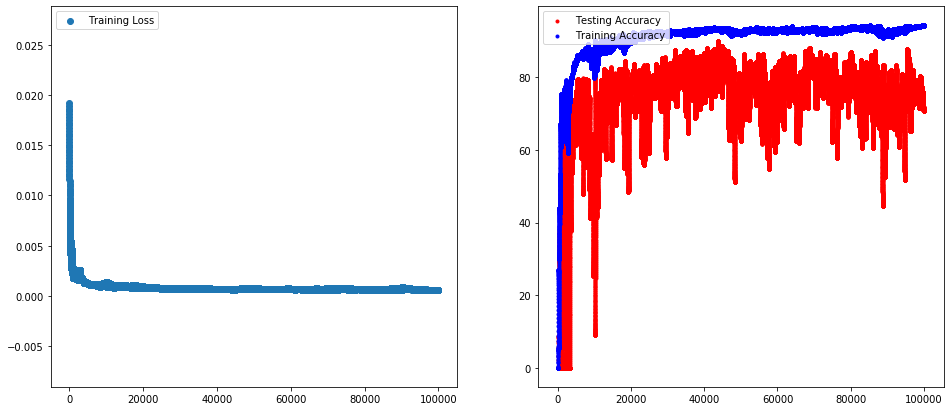

Min Loss: 0.0005434097838588059 at iteration: 99988, Max R2 Score: 89.8


In [7]:
#Train Model w/ Data Tx
number_of_inputs,number_of_outputs = get_hyper_parameters(with_tx=True)
Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,torch.Tensor(train_x_tx.values),torch.Tensor(train_y_tx.values),torch.Tensor(test_x_tx.values),torch.Tensor(test_y_tx.values),with_tx=True)

Iteration Number [0/100000], Loss 0.00420, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [1000/100000], Loss 0.00139, Train Dataset Accuracy: 62.55, Test Dataset Accuracy: 65.03
Iteration Number [2000/100000], Loss 0.00121, Train Dataset Accuracy: 69.18, Test Dataset Accuracy: 70.39
Iteration Number [3000/100000], Loss 0.00143, Train Dataset Accuracy: 65.74, Test Dataset Accuracy: 67.83
Iteration Number [4000/100000], Loss 0.00124, Train Dataset Accuracy: 68.42, Test Dataset Accuracy: 68.77
Iteration Number [5000/100000], Loss 0.00123, Train Dataset Accuracy: 68.31, Test Dataset Accuracy: 70.76
Iteration Number [6000/100000], Loss 0.00118, Train Dataset Accuracy: 70.27, Test Dataset Accuracy: 71.83
Iteration Number [7000/100000], Loss 0.00118, Train Dataset Accuracy: 70.36, Test Dataset Accuracy: 72.24
Iteration Number [8000/100000], Loss 0.00117, Train Dataset Accuracy: 70.63, Test Dataset Accuracy: 72.4
Iteration Number [9000/100000], Loss 0.00116, Train Datase

Iteration Number [77000/100000], Loss 0.00118, Train Dataset Accuracy: 70.52, Test Dataset Accuracy: 72.44
Iteration Number [78000/100000], Loss 0.00116, Train Dataset Accuracy: 71.51, Test Dataset Accuracy: 72.29
Iteration Number [79000/100000], Loss 0.00120, Train Dataset Accuracy: 69.58, Test Dataset Accuracy: 71.56
Iteration Number [80000/100000], Loss 0.00114, Train Dataset Accuracy: 71.92, Test Dataset Accuracy: 73.33
Iteration Number [81000/100000], Loss 0.00121, Train Dataset Accuracy: 69.06, Test Dataset Accuracy: 70.29
Iteration Number [82000/100000], Loss 0.00117, Train Dataset Accuracy: 70.89, Test Dataset Accuracy: 73.3
Iteration Number [83000/100000], Loss 0.00114, Train Dataset Accuracy: 72.01, Test Dataset Accuracy: 73.71
Iteration Number [84000/100000], Loss 0.00116, Train Dataset Accuracy: 71.19, Test Dataset Accuracy: 73.02
Iteration Number [85000/100000], Loss 0.00113, Train Dataset Accuracy: 72.25, Test Dataset Accuracy: 73.65
Iteration Number [86000/100000], Loss 

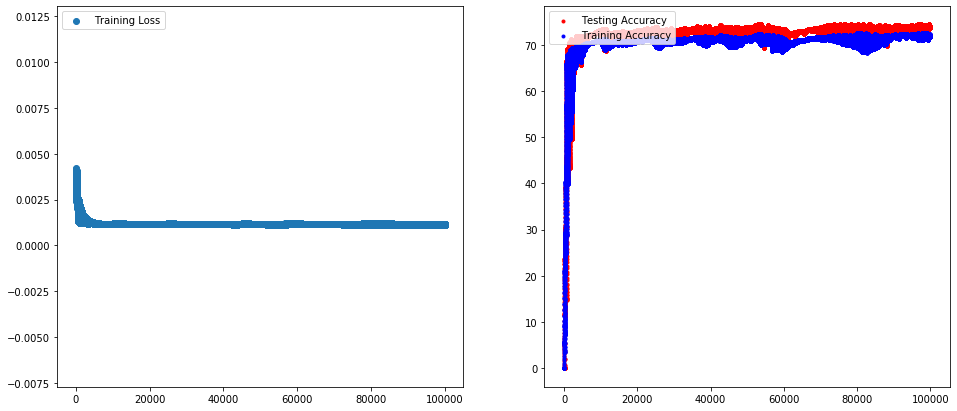

Min Loss: 0.0011245532659813762 at iteration: 80371, Max R2 Score: 74.61


In [9]:
#Train Model w/ Data No Tx
number_of_inputs,number_of_outputs = get_hyper_parameters(with_tx=False)
Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,torch.Tensor(train_x_no_tx.values),torch.Tensor(train_y_no_tx.values),torch.Tensor(test_x_no_tx.values),torch.Tensor(test_y_no_tx.values),with_tx=False)